<a href="https://colab.research.google.com/github/martimov/MoniTARE/blob/main/Area_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import cv2 as cv
from google.colab.patches import cv2_imshow
from sklearn.cluster import MeanShift, estimate_bandwidth
import os
import matplotlib.pyplot as plt
import numpy as np
import math

# Allows to render matplotlib figures directly in the notebook
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (26.0, 14.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [ ]:
%cd /content/drive/MyDrive/MoniTARE

/content/drive/MyDrive/MoniTARE


(1080, 1920, 3)


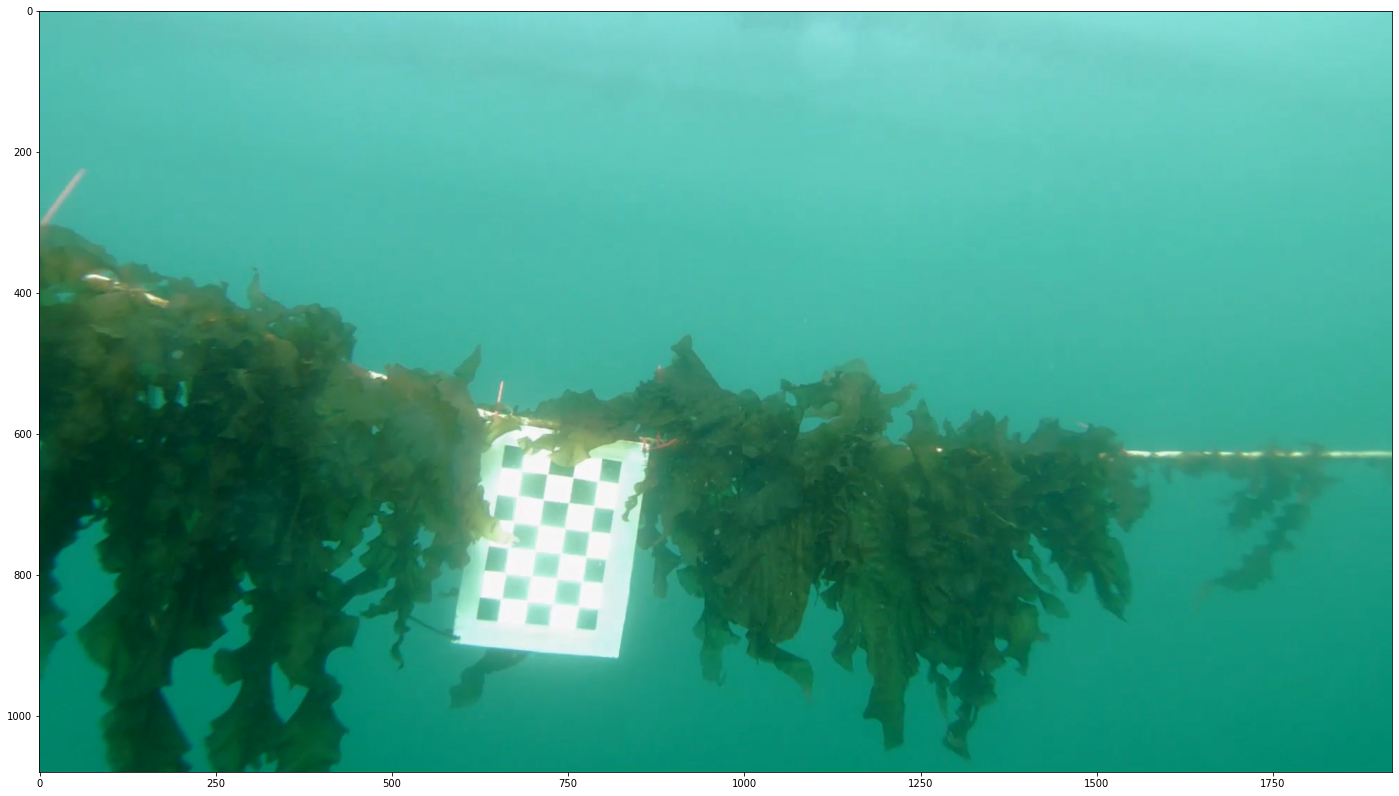

In [ ]:
# Load an image and display
imgPath = 'video_BYEDP210102_2022-04-05_111910_wideshot.mp4_snapshot_00.08.574.jpg'
img = cv.imread(imgPath, cv.IMREAD_COLOR)

# Convert to grayscale
imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Display image
plt.imshow(img[:, :, ::-1]);
print(img.shape)

# Perspective correction

In [ ]:
################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (4, 6)
frameSize = (1920, 1080)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

In [ ]:
# Find the chess board corners
ret, corners = cv.findChessboardCorners(imgGray, chessboardSize, None)

# Copy image
imgCorners = img.copy()

# If found, add object points, image points (after refining them)
if ret == True:
  objpoints.append(objp)
  
  corners = cv.cornerSubPix(imgGray, corners, (11,11), (-1,-1), criteria)
  imgpoints.append(corners)
  # Draw and display the corners
  imgCopy = cv.drawChessboardCorners(imgCorners, chessboardSize, corners, ret)
  plt.imshow(imgCorners[:, :, ::-1]);

if ret == False:
  print('Can not find corners')

Can not find corners


In [ ]:
# save the corner output
cv.imwrite('video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663_corners.jpg', imgCorners)

True

In [ ]:
# Extract the four corner points.
quad = [corners[0], corners[3], corners[23], corners[20]]

# Define the four corners points to prevent defining input as list in list.
input = np.float32([corner[0] for corner in quad])

print(input)

[[422.08246 708.2529 ]
 [506.34476 686.9322 ]
 [548.57983 845.7995 ]
 [464.06226 864.87213]]


In [ ]:
# Define the size of the output image.
hh, ww = img.shape[:2]

# Get top and left dimensions and set to output dimensions of chessboard.
# The math.hypot() method returns the Euclidean norm. The Euclidian norm is the distance from the origin to the coordinates given.
# width = math.hypot(x1 - x2, y1 - y2)
# height = math.hypot(x1 - x4, y1 - y4)
width = math.hypot(input[0,0]-input[1,0], input[0,1]-input[1,1])
height = math.hypot(input[0,0]-input[3,0], input[0,1]-input[3,1])
print("width:",width, "height:",height)

# Set upper left coordinates for output chessboard (same as upper left coordinates for the input chessboard).
x = input[0,0]
y = input[0,1]

# Specify output coordinates for corners of chessboard in order TL, TR, BR, BL as x.
output = np.float32([[x,y], [x+width-1,y], [x+width-1,y+height-1], [x,y+height-1]])
print(output)

width: 86.91782847021202 height: 162.14770339208278
[[422.08246 708.2529 ]
 [508.00027 708.2529 ]
 [508.00027 869.40063]
 [422.08246 869.40063]]


In [ ]:
# compute perspective matrix
matrix = cv.getPerspectiveTransform(input, output)
print(matrix)

[[ 1.04895456e+00 -2.91599776e-01  1.93284163e+02]
 [ 3.54193529e-01  9.30560618e-01 -8.78664463e+01]
 [ 1.51136301e-04 -6.52464563e-05  1.00000000e+00]]


In [ ]:
# do perspective transformation setting area outside input to black
# Note that output size is the same as the input image size
imgWarp = cv.warpPerspective(img, matrix, (ww,hh), cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=(0,0,0))

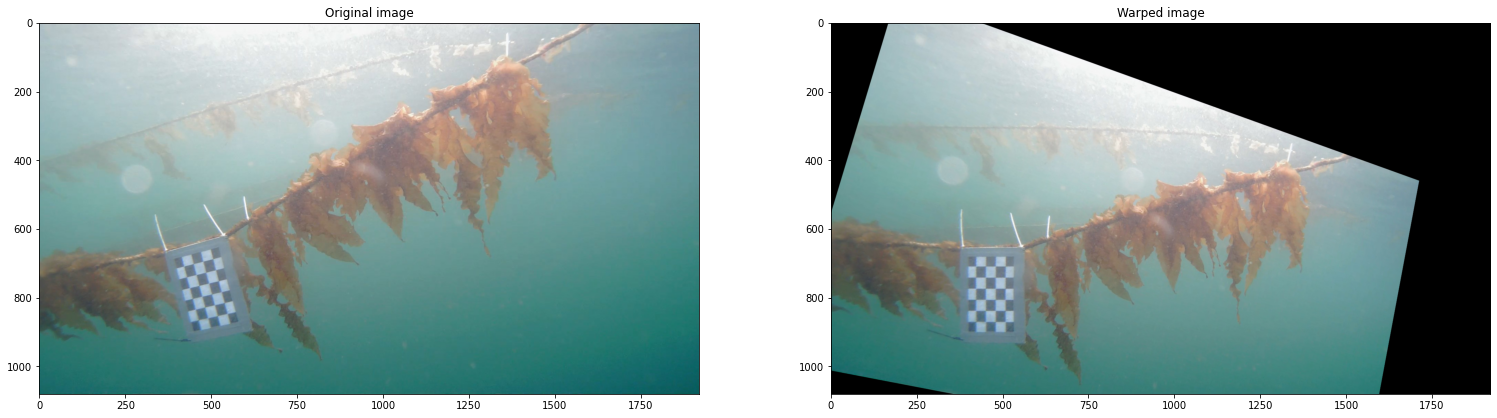

In [ ]:
plt.figure()
plt.subplot(121); plt.imshow(img[:, :, ::-1]), plt.title('Original image')
plt.subplot(122); plt.imshow(imgWarp[:, :, ::-1]), plt.title('Warped image');

In [ ]:
# save the warped output
cv.imwrite('video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663_warped.jpg', imgWarp)

True

# MeanShift

In [ ]:
### PARAM TESTING LOOPS ###
# iterations = [1, 2, 4, 8, 16]
# for i in iterations:

# samples = [30, 300, 3000]
# for n in samples:

# quantiles = [.2, .15, .1, .05]
# for q in quantiles:

# Noise reduction filter

## Median Filter
Median blur filtering is a nonlinear filtering technique that is most commonly used to remove salt-and-pepper noise from images. As the name suggests, salt-and-pepper noise shows up as randomly occurring white and black pixels that are sharply different from the surrounding. In color images, salt-and-pepper noise may appear as small random color spots.

## Bilateral Filtering

A Bilateral Filter is nonlinear, edge-preserving and noise-reducing smoothing filter. Most smoothing filters (e.g. a Gaussian or a Box filter) have a parameter called σ_s (the s in the subscript stands for "spatial") that determines the amount of smoothing. Often this value is closely related to the kernel size. A typical smoothing filter replaces the intensity value of a pixel by the weighted sum of its neighbors. The bigger the neighborhood, the smoother the filtered image looks. The size of the neighborhood is directly proportional to the parameter σ_s.

In edge-preserving filters, there are two competing objectives:

1. Smooth the image.
2. Don’t smooth the edges / color boundaries.

In other words, if we want to preserve edges, we cannot simply replace the color of a pixel by the weighted sum of its neighbors.

## Conclusion
Median filtering works best on images with salt and pepper type noise.
Bilateral filtering helps smooth noise while maintaining sharp edges.

In [ ]:
# Filter to reduce noise (test/research if median, bilateral or Gaussian filter is best)
imgWarp = cv.medianBlur(imgWarp, 3)

# Flatten the image
imgFlat = imgWarp.reshape((-1,3))
imgFlat = np.float32(imgFlat)

In [ ]:
# meanshift
bandwidth = estimate_bandwidth(imgFlat, quantile=.15, n_samples=300)

ms = MeanShift(bandwidth=bandwidth, max_iter=16, bin_seeding=True)

ms.fit(imgFlat)
labeled = ms.labels_

# get number of segments
segments = np.unique(labeled)

# get the average color of each segment
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
  total[label] = total[label] + imgFlat[i]
  count[label] += 1
avg = total/count
avg = np.uint8(avg)

# cast the labeled image into the corresponding avg color
res = avg[labeled]
imgMS = res.reshape((imgWarp.shape))

bandwidth: 32.728722933085734
Number of segments:  8


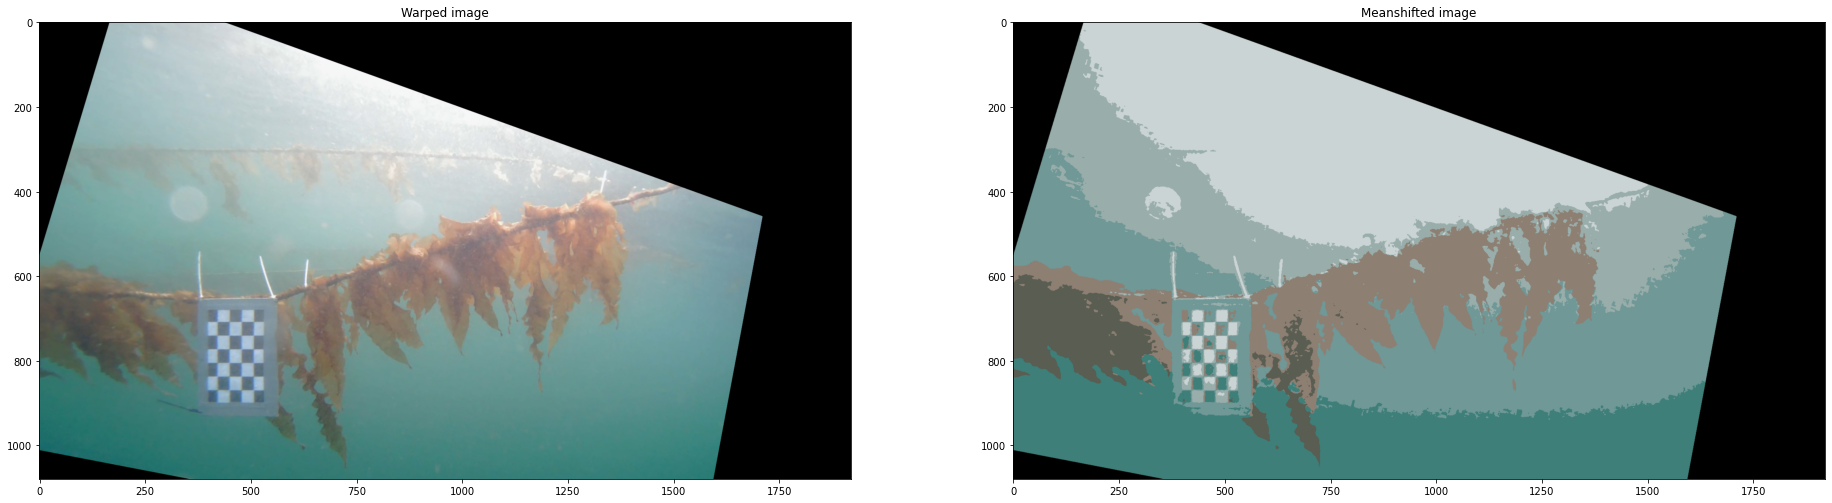

In [ ]:
print("bandwidth:", bandwidth)
print('Number of segments: ', segments.shape[0])
plt.figure(figsize = [32, 20])
plt.subplot(121); plt.imshow(imgWarp[:, :, ::-1]), plt.title('Warped image')
plt.subplot(122); plt.imshow(imgMS[:, :, ::-1]), plt.title('Meanshifted image');

In [ ]:
# meanshift
bandwidth = estimate_bandwidth(imgFlat, quantile=.05, n_samples=300)

ms = MeanShift(bandwidth=bandwidth, max_iter=16, bin_seeding=True)

ms.fit(imgFlat)
labeled = ms.labels_

# get number of segments
segments = np.unique(labeled)

# get the average color of each segment
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
  total[label] = total[label] + imgFlat[i]
  count[label] += 1
avg = total/count
avg = np.uint8(avg)

# cast the labeled image into the corresponding avg color
res = avg[labeled]
imgMS = res.reshape((imgWarp.shape))

bandwidth: 14.313886593575116
Number of segments:  38


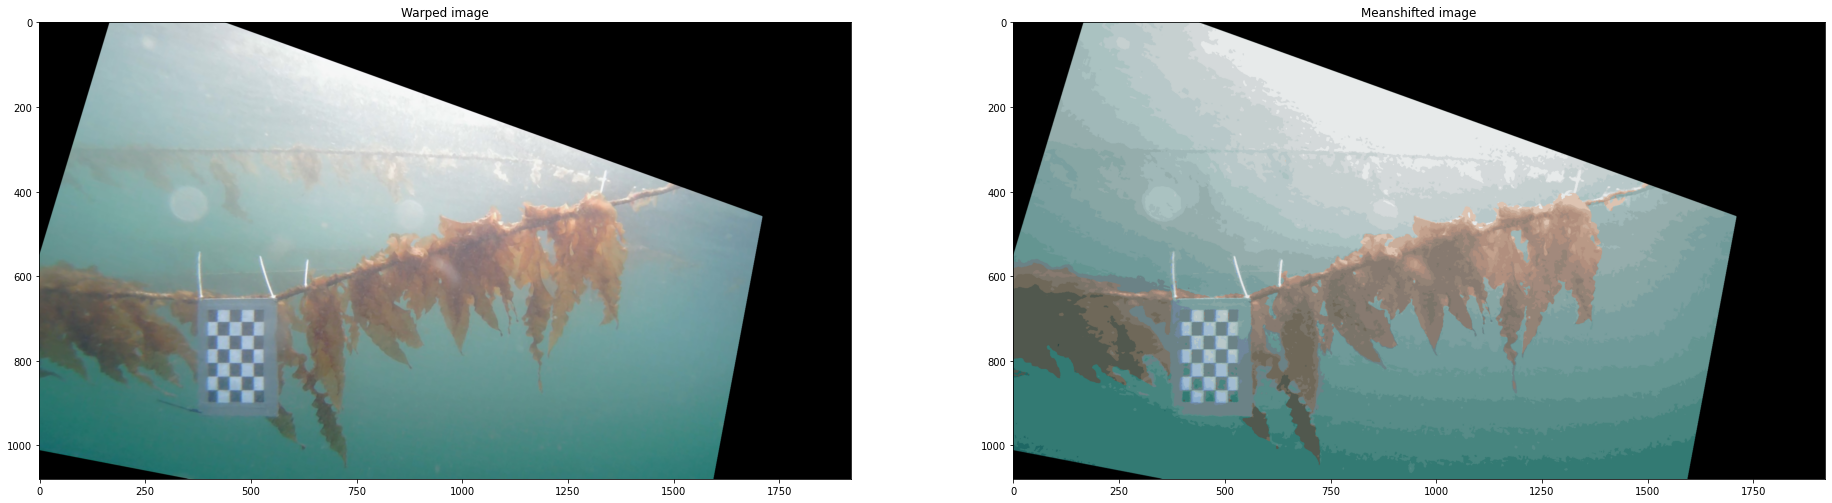

In [ ]:
print("bandwidth:", bandwidth)
print('Number of segments: ', segments.shape[0])
plt.figure(figsize = [32, 20])
plt.subplot(121); plt.imshow(imgWarp[:, :, ::-1]), plt.title('Warped image')
plt.subplot(122); plt.imshow(imgMS[:, :, ::-1]), plt.title('Meanshifted image');

In [ ]:
# save the Meanshift output
cv.imwrite('video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663_MS.jpg', imgMS)

True

# Region of interest

In [ ]:
fillPoly()
Module 9 - Lane Detection using Hough Transforms 

# Area estimation

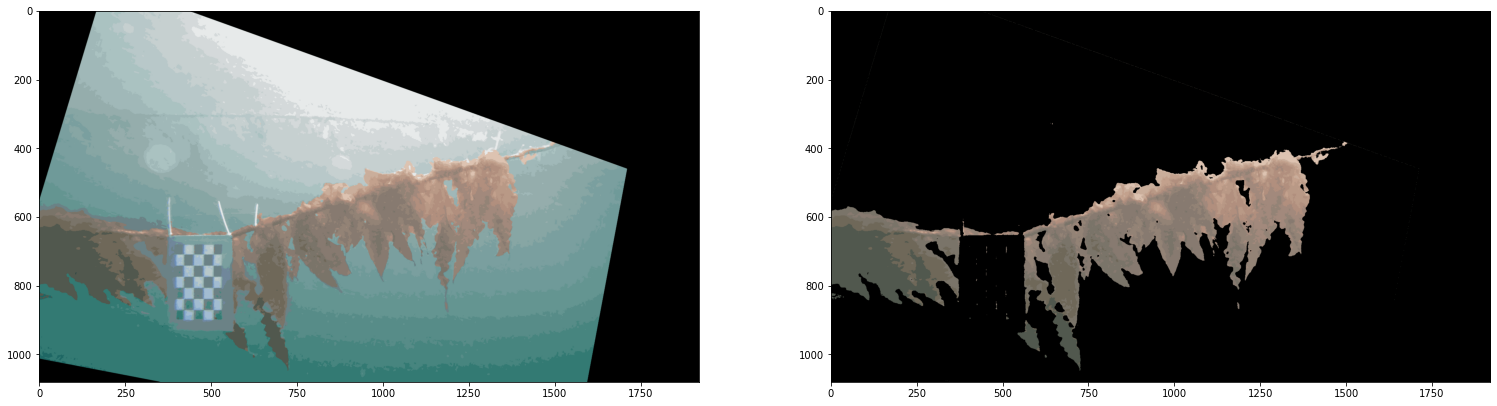

In [ ]:
# Convert to HSV (use: cvtColor()).
imgHSV = cv.cvtColor(imgMS, cv.COLOR_BGR2HSV)

# Specify the lower and upper bound to segment the kelp in the image.
k_lb = np.array([0, 20, 50], np.uint8)
k_ub = np.array([70, 255, 255], np.uint8)

# Create a kelp mask (use: inRange()).
imgMask = cv.inRange(imgHSV, k_lb, k_ub)

# Segment the kelp (use bitwise_and()).
imgSeg = cv.bitwise_and(imgMS, imgMS, mask = imgMask)

# Display the original image and the segmented kelp.
plt.figure()
plt.subplot(121); plt.imshow(imgMS[:, :, ::-1])
plt.subplot(122); plt.imshow(imgSeg[:, :, ::-1]);

In [ ]:
# save the segmented output
cv.imwrite("video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663_seg.jpg", imgSeg)

True

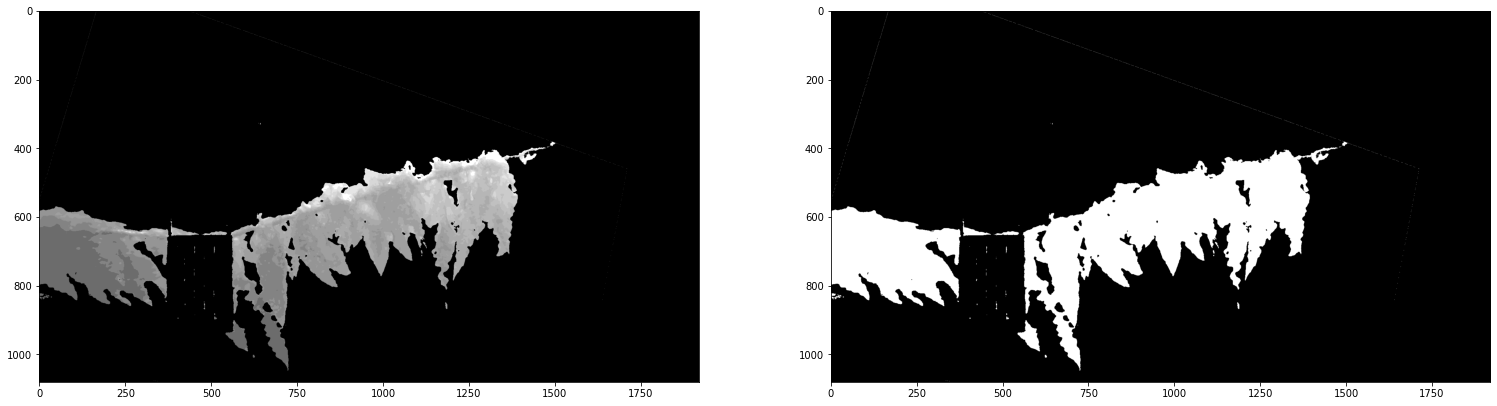

In [ ]:
imgSegGray = cv.cvtColor(imgSeg, cv.COLOR_BGR2GRAY)

# Perform adaptive Gaussian thresholding.
imgThresh = cv.adaptiveThreshold(imgSegGray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 1079, 0)

plt.figure()
plt.subplot(121); plt.imshow(imgSegGray)
plt.subplot(122); plt.imshow(imgThresh);

In [ ]:
# save the thresholded output
cv.imwrite('video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663_thresh.jpg', imgThresh)

True

In [ ]:
# Find all contours in the thresholded image.
contours, hierarchy = cv.findContours(imgThresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# Number of contours and hierarchy in the thresholded image.
print("Number of contours found (thresholded) = {}".format(len(contours)))
print("\nHierarchy (thresholded): \n{}".format(hierarchy))

Number of contours found (thresholded) = 575

Hierarchy (thresholded): 
[[[  1  -1  -1  -1]
  [  2   0  -1  -1]
  [  3   1  -1  -1]
  ...
  [573 571  -1  -1]
  [574 572  -1  -1]
  [ -1 573  -1  -1]]]


Change the contour drawing from area > 100000 to area > maxArea, to ensure that largest contour always is drawn independent on the contour pixel sizes.

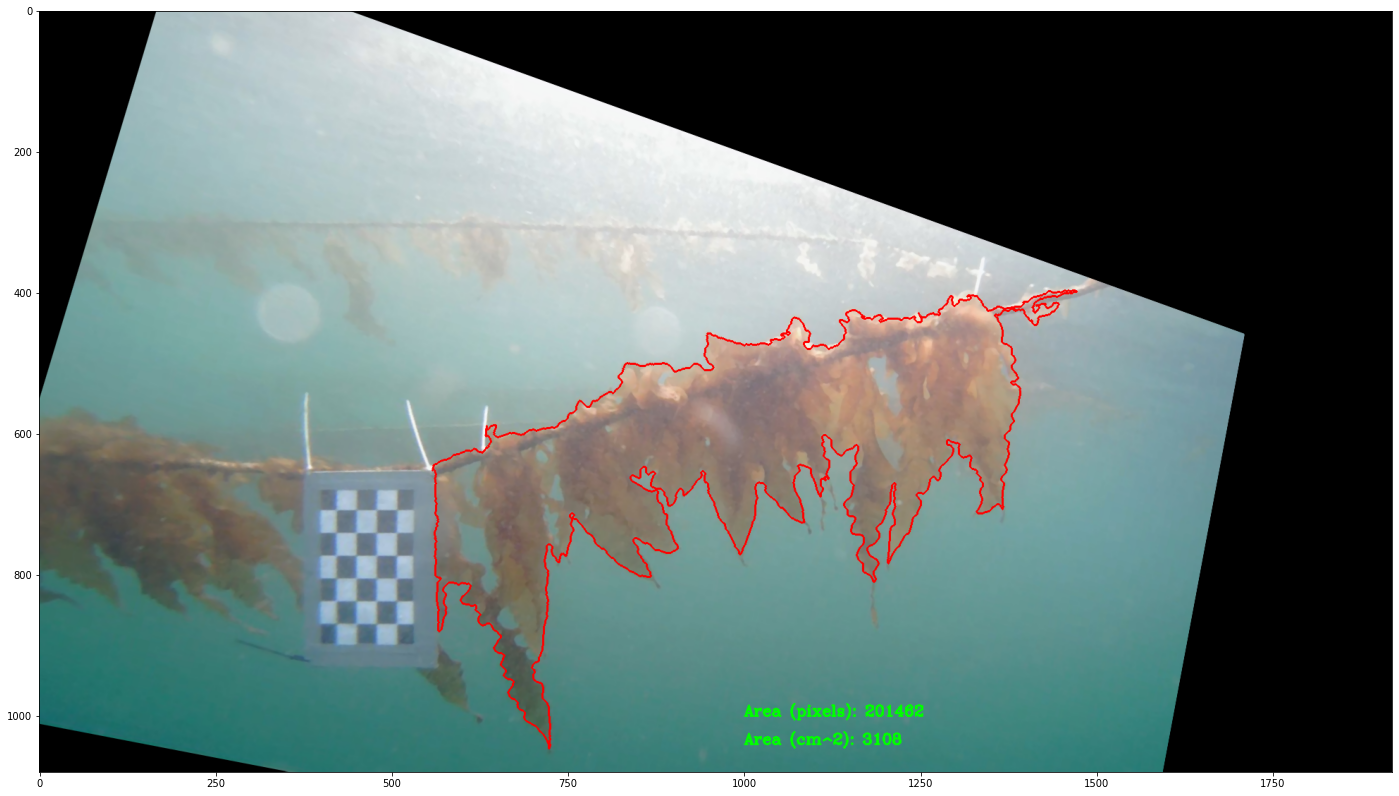

In [ ]:
# Copy image
imgWarpCopy = imgWarp.copy()

# Draw largest contour (Change the contour drawing from area > 100000 to area > maxArea, to ensure that largest contour always is drawn independent on the contour pixel sizes).
for cnt in contours:
  area = cv.contourArea(cnt)
  if area > 100000:
    cv.drawContours(imgWarpCopy, cnt, -1, (0,0,255), 2)
    cv.putText(imgWarpCopy, 'Area (pixels): ' + str(int(area)), (1000, 1000), cv.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
    cv.putText(imgWarpCopy, 'Area (cm^2): ' + str(int(area/(8.05*8.05))), (1000, 1040), cv.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
    plt.imshow(imgWarpCopy[:, :, ::-1]);

In [ ]:
# save the contour output
cv.imwrite('video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663_calc.jpg', imgWarpCopy)

True

# Plotting results

Matplot has plotting functions that I can use directly in the script

In [ ]:
# plt.plot()

# Stack images

In [ ]:
# Show intermediate results in a stacked image
imgStack = stackImages() 
# https://www.youtube.com/watch?v=WQeoO7MI0Bs&t=4585s

# Alternative contour drawing

In [ ]:
# Thresholded.
max_area = -1
for i in range(len(contours)):
    area = cv.contourArea(contours[i])
    if area>max_area:
        cnt = contours[i]
        max_area = area
        print("Thresholded contour #{} has area = {}".format(i+1,area))

Thresholded contour #1 has area = 0.0
Thresholded contour #4 has area = 32.0
Thresholded contour #6 has area = 179.0
Thresholded contour #7 has area = 2578.0
Thresholded contour #53 has area = 2778.0
Thresholded contour #114 has area = 75214.0
Thresholded contour #232 has area = 203299.0


Thresholded contour #232 has area =  203299.0


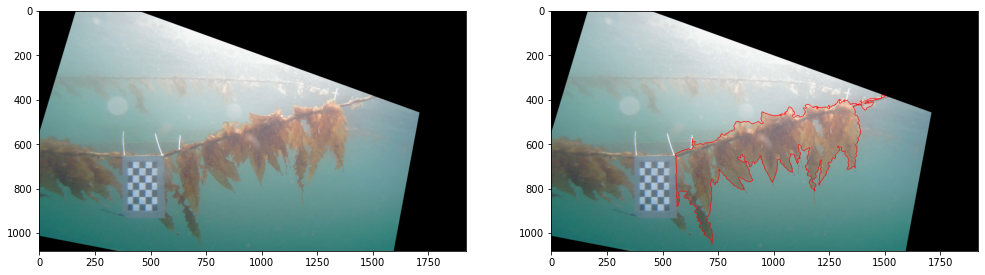

In [ ]:
# Copy image
imgWarpCopy = imgWarp.copy()

# Draw contours (contour # is one lower than actual).
imgCnt = cv.drawContours(imgWarpCopy, contours[231], -1, (0,0,255), 2)

# Estimate area.
area232 = cv.contourArea(cnt)

# Display.
plt.figure()
plt.subplot(131); plt.imshow(imgWarp[:, :, ::-1])
plt.subplot(132); plt.imshow(imgCnt[:, :, ::-1]);

print('Thresholded contour #232 has area = ', area232)

In [ ]:
# save the contour output
cv.imwrite("video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663_cnt.jpg", imgCnt)

True